In [19]:
import pandas as pd 

In [20]:
data = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
data.head()

C:\Users\khush\AppData\Local\Temp\ipykernel_9192\18878662.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


In [21]:
train_size = int(len(data) * 0.95)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)] 
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']]) 
test['close'] = scaler.transform(test[['close']])

C:\Users\khush\AppData\Local\Temp\ipykernel_9192\2753238880.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
C:\Users\khush\AppData\Local\Temp\ipykernel_9192\2753238880.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close'] = scaler.transform(test[['close']])


In [23]:
import numpy as np

In [24]:
def create_seq(X, y, time_steps=1): 
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values 
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [25]:
X_train, y_train = create_seq(train[['close']], train.close, 30)
X_test, y_test = create_seq(test[['close']], test.close, 30)

print(X_train.shape)
print(X_test.shape)

(7752, 30, 1)
(380, 30, 1)


In [26]:
import tensorflow as tf
from tensorflow import keras

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 

In [28]:
X_train.shape

(7752, 30, 1)

In [29]:
model = keras.Sequential() 
model.add(keras.layers.LSTM(units=64,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.RepeatVector(n=X_train.shape[1])) 
model.add(keras.layers.LSTM(units=64, return_sequences=True)) 
model.add(keras.layers.TimeDistributed( keras.layers.Dense(units=X_train.shape[2])))

model.compile(loss='mae', optimizer='adam')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 64)            0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 30, 64)            33024     
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 1)             65        
 stributed)                                                      
                                                                 
Total params: 49985 (195.25 KB)
Trainable params: 49985 (195.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
history = model.fit( X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
218/218 [==============================] - 5s 14ms/step - loss: 0.1461 - val_loss: 0.3505
Epoch 2/10
218/218 [==============================] - 3s 14ms/step - loss: 0.0765 - val_loss: 0.2830
Epoch 3/10
218/218 [==============================] - 3s 14ms/step - loss: 0.0816 - val_loss: 0.2352
Epoch 4/10
218/218 [==============================] - 3s 13ms/step - loss: 0.0870 - val_loss: 0.1992
Epoch 5/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1064 - val_loss: 0.2884
Epoch 6/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1267 - val_loss: 0.2540
Epoch 7/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1223 - val_loss: 0.2519
Epoch 8/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1191 - val_loss: 0.2017
Epoch 9/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1211 - val_loss: 0.1903
Epoch 10/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1164 - val_lo

In [32]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 7ms/step - loss: 0.6255


0.6255102753639221

In [33]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

243/243 [==============================] - 2s 6ms/step


In [34]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

12/12 [==============================] - 0s 6ms/step


Reconstruction error threshold: 0.8116613822372073


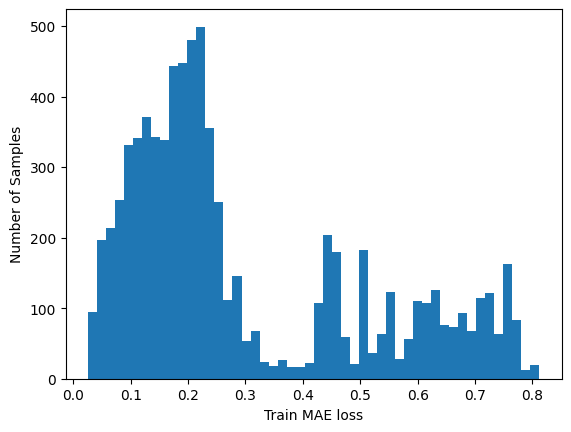

In [38]:
import matplotlib.pyplot as plt
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)

print(f'Reconstruction error threshold: {threshold}')

In [36]:
test_score_df = pd.DataFrame(index=test[30:].index) 
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold 
test_score_df['close'] = test[30:].close

In [37]:
anomalies = test_score_df[test_score_df.anomaly == True] 
anomalies.head()

,loss,threshold,anomaly,close
date,,,,
2018-02-05,0.828416,0.811661,True,3.106679
2018-02-06,0.867417,0.811661,True,3.193456
2018-02-07,0.894354,0.811661,True,3.168136
2018-02-08,0.911176,0.811661,True,2.979068
2018-02-09,0.941143,0.811661,True,3.051476
